<a href="https://colab.research.google.com/github/aryanj1412/mapf-optimization-project/blob/main/ICTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from heapq import heappush, heappop
from collections import deque, defaultdict
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [12]:
# ------------- Grid and helpers -------------
DIRS = [(0,1),(1,0),(0,-1),(-1,0)]  # 4-connected moves

def in_bounds(grid, x, y):
    return 0 <= x < len(grid) and 0 <= y < len(grid[0])

def is_free(grid, x, y):
    return in_bounds(grid, x, y) and grid[x][y] == 0

def manhattan(a,b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

# ------------- A* for shortest path (no time) -------------
def astar_shortest_length(grid, start, goal):
    """Return the length (cost) of a shortest path ignoring time/waits. If unreachable, return None."""
    openq = []
    gscore = {start: 0}
    fscore = {start: manhattan(start,goal)}
    heappush(openq, (fscore[start], start))
    visited = set()
    while openq:
        f, cur = heappop(openq)
        if cur in visited:
            continue
        visited.add(cur)
        if cur == goal:
            return gscore[cur]
        for dx,dy in DIRS:
            nx,ny = cur[0]+dx, cur[1]+dy
            if not is_free(grid, nx, ny):
                continue
            tentative = gscore[cur] + 1
            if tentative < gscore.get((nx,ny), 1e9):
                gscore[(nx,ny)] = tentative
                fscore[(nx,ny)] = tentative + manhattan((nx,ny), goal)
                heappush(openq, (fscore[(nx,ny)], (nx,ny)))
    return None

# ------------- Enumerate all individual paths with exact length L -------------
def enumerate_paths_of_length(grid, start, goal, length, max_paths=None):
    """
    Enumerate all time-expanded (vertex-time) paths from start to goal with EXACT length `length`.
    Moves cost 1; waiting at same cell costs 1 (i.e., action 'wait').
    We do DFS with pruning using Manhattan heuristic.
    Returns list of lists of coordinates (len = length+1, including time 0..length).
    """
    results = []
    stack = [(start, 0, [start])]  # (pos, time, path)
    # Use visited states with (pos, time) to avoid revisiting same (pos,time) in same branch
    while stack:
        pos, t, path = stack.pop()
        remaining = length - t
        # heuristic pruning: min steps needed to reach goal
        h = manhattan(pos, goal)
        if h > remaining:
            continue
        if t == length:
            if pos == goal:
                results.append(path.copy())
                if max_paths and len(results) >= max_paths:
                    return results
            continue
        # expand: all moves + wait
        # We iterate neighbors and wait. For deterministic behavior, we can add wait last or first.
        # We'll prioritize moving directions first (heuristic).
        neighbors = []
        for dx,dy in DIRS:
            nx,ny = pos[0]+dx, pos[1]+dy
            if is_free(grid,nx,ny):
                neighbors.append((nx,ny))
        # include wait
        neighbors.append(pos)
        # push next states
        for npos in neighbors:
            # small optimization: do not revisit same (npos, t+1) in same path
            # but because path contains vertices, we can avoid cycles at same times maybe not necessary
            stack.append((npos, t+1, path + [npos]))
    return results

# ------------- Collision checking between complete solution paths -------------
def detect_collision(paths):
    """
    Given list of agent paths (each is list of coordinates indexed by time 0..T),
    detect vertex or edge collisions. If no collisions, return None.
    If collision found return dict with info.
    Allows agents to have different path lengths; shorter ones are assumed to wait at goal afterwards.
    Vertex collision: two agents at same cell at same time.
    Edge collision: swap positions between t->t+1.
    """
    num_agents = len(paths)
    max_t = max(len(p) for p in paths) - 1
    # pad with last location (wait at goal)
    padded = []
    for p in paths:
        if len(p) - 1 < max_t:
            last = p[-1]
            padded.append(p + [last] * (max_t - (len(p)-1)))
        else:
            padded.append(p)
    # check vertex collisions
    for t in range(max_t+1):
        pos_time = defaultdict(list)
        for i in range(num_agents):
            pos_time[padded[i][t]].append(i)
        for pos, agents in pos_time.items():
            if len(agents) > 1:
                return {"type":"vertex", "time":t, "pos":pos, "agents":agents}
    # check edge collisions (swap)
    for t in range(max_t):
        edge_time = {}
        for i in range(num_agents):
            a_from, a_to = padded[i][t], padded[i][t+1]
            edge_time[i] = (a_from, a_to)
        for i,j in itertools.combinations(range(num_agents), 2):
            if edge_time[i][0] == edge_time[j][1] and edge_time[i][1] == edge_time[j][0]:
                return {"type":"edge", "time":t+0.5, "agents":[i,j], "swap":(edge_time[i], edge_time[j])}
    return None

# ------------- ICTS main algorithm -------------
def ict_search(grid, agents, max_paths_per_agent=2000):
    """
    agents: list of (start, goal) pairs where start and goal are (x,y) tuples.
    Returns: list of paths (list of coords) for each agent, or None if unsolvable.
    max_paths_per_agent: cap on enumerated paths per agent for each tuple (to avoid explosion).
    """
    n = len(agents)
    # 1. compute individual shortest lengths
    min_costs = []
    for (s,g) in agents:
        l = astar_shortest_length(grid, s, g)
        if l is None:
            print(f"Agent {s}->{g} unreachable (obstacle) -> no solution.")
            return None
        min_costs.append(l)
    # priority queue (sum-cost, tuple-costs)
    visited_cost_tuples = set()
    pq = []
    start_tuple = tuple(min_costs)
    heappush(pq, (sum(start_tuple), start_tuple))
    visited_cost_tuples.add(start_tuple)
    # expand tuples in nondecreasing sum order
    while pq:
        total, cost_tuple = heappop(pq)
        # For debugging
        # print("Trying cost tuple", cost_tuple, "sum=", total)
        # 2. For this cost tuple, enumerate per-agent paths of exact length
        all_agent_paths = []
        feasible = True
        for i,((s,g), cost_i) in enumerate(zip(agents, cost_tuple)):
            # enumerate paths of exactly cost_i
            paths_i = enumerate_paths_of_length(grid, s, g, cost_i, max_paths_per_agent)
            if not paths_i:
                feasible = False
                break
            all_agent_paths.append(paths_i)
        if not feasible:
            # generate successor tuples
            for i in range(n):
                new = list(cost_tuple)
                new[i] += 1
                newt = tuple(new)
                if newt not in visited_cost_tuples:
                    visited_cost_tuples.add(newt)
                    heappush(pq, (sum(newt), newt))
            continue
        # 3. Combine agent paths (CSP backtracking) to find a collision-free set
        solution = combine_agent_paths_backtracking(all_agent_paths)
        if solution is not None:
            return solution
        # 4. If not found, generate successor tuples by increasing one agent's cost by 1
        for i in range(n):
            new = list(cost_tuple)
            new[i] += 1
            newt = tuple(new)
            if newt not in visited_cost_tuples:
                visited_cost_tuples.add(newt)
                heappush(pq, (sum(newt), newt))
    # exhausted
    return None

def combine_agent_paths_backtracking(all_agent_paths):
    """
    all_agent_paths: list of lists; all_agent_paths[i] is the list of candidate paths for agent i.
    We perform backtracking combining one path per agent and check incremental collisions for pruning.
    Returns list of chosen paths or None.
    """
    n = len(all_agent_paths)
    chosen = [None] * n

    # Pre-calc path lengths (for padding)
    def backtrack(i):
        if i == n:
            # full assignment: check full collision
            coll = detect_collision(chosen)
            if coll is None:
                return chosen.copy()
            return None
        for p in all_agent_paths[i]:
            chosen[i] = p
            # incremental collision check with already chosen agents
            coll = detect_collision(chosen[:i+1])
            if coll is None:
                res = backtrack(i+1)
                if res is not None:
                    return res
            # else try next path
            chosen[i] = None
        return None

    return backtrack(0)

# ------------- Utilities to pretty print paths -------------
def pretty_print_solution(grid, agents, paths):
    print("Solution found:")
    max_t = max(len(p) for p in paths) - 1
    for t in range(max_t+1):
        print(f"t={t}")
        grid_copy = [['#' if grid[i][j]==1 else '.' for j in range(len(grid[0]))] for i in range(len(grid))]
        for a,p in enumerate(paths):
            pos = p[t] if t < len(p) else p[-1]
            x,y = pos
            grid_copy[x][y] = str(a)
        for row in grid_copy:
            print(''.join(row))
        print()
    for i,(s,g) in enumerate(agents):
        print(f"Agent {i}: start={s}, goal={g}, path_len={len(paths[i])-1}")

#-------------Visualization-----------------
def visualize_paths(grid, agents, paths, delay=0.5):
    """
    Visualize the multi-agent paths step-by-step using matplotlib animation.
    Compatible with older Matplotlib versions.
    grid: 2D list (0=free, 1=obstacle)
    agents: list of (start, goal)
    paths: list of lists of coordinates for each agent
    delay: frame delay in seconds
    """
    nrows, ncols = len(grid), len(grid[0])
    max_t = max(len(p) for p in paths) - 1

    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, ncols - 0.5)
    ax.set_ylim(-0.5, nrows - 0.5)
    ax.set_aspect('equal')
    ax.invert_yaxis()  # So (0,0) is top-left like grid print
    plt.xticks(range(ncols))
    plt.yticks(range(nrows))
    plt.grid(True)

    # Draw obstacles
    for i in range(nrows):
        for j in range(ncols):
            if grid[i][j] == 1:
                ax.add_patch(patches.Rectangle((j - 0.5, i - 0.5), 1, 1, color='black'))

    # --- Fixed colormap handling ---
    colors = plt.cm.get_cmap('tab10')
    agent_circles = []
    agent_labels = []

    # Initialize agent markers
    for a, path in enumerate(paths):
        x, y = path[0][1], path[0][0]
        color = colors(a / len(agents))  # normalize for N agents
        circ = plt.Circle((x, y), 0.3, color=color, label=f"Agent {a}")
        txt = ax.text(x, y, str(a), color='white', ha='center', va='center', fontsize=9, weight='bold')
        agent_circles.append(circ)
        agent_labels.append(txt)
        ax.add_patch(circ)

    ax.legend(loc='upper right')

    # --- Update function for animation ---
    def update(frame):
        for a, path in enumerate(paths):
            pos = path[frame] if frame < len(path) else path[-1]
            i, j = pos
            agent_circles[a].center = (j, i)
            agent_labels[a].set_position((j, i))
        ax.set_title(f"t = {frame}")
        return agent_circles + agent_labels

    # --- Animation creation ---
    ani = FuncAnimation(fig, update, frames=max_t + 1, interval=delay * 1000, blit=True, repeat=False)

    # --- Save animation as GIF ---
    ani.save('out.gif', writer='imagemagick')

    # --- For Jupyter/Colab ---
    try:
        from IPython.display import HTML
        return HTML(ani.to_jshtml())
    except Exception:
        plt.show()


/tmp/ipython-input-3110051781.py:258: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


Solution found:
t=0
0...1
.###.
...#.
.#...
.....

t=1
...1.
0###.
...#.
.#...
.....

t=2
..1..
.###.
0..#.
.#...
.....

t=3
.1...
.###.
...#.
0#...
.....

t=4
1....
.###.
...#.
.#...
0....

t=5
.....
1###.
...#.
.#...
.0...

t=6
.....
.###.
1..#.
.#...
..0..

t=7
.....
.###.
...#.
1#...
...0.

t=8
.....
.###.
...#.
.#...
1...0

Agent 0: start=(0, 0), goal=(4, 4), path_len=8
Agent 1: start=(0, 4), goal=(4, 0), path_len=8


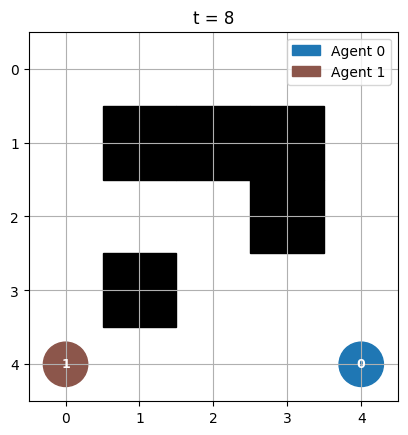

In [13]:
if __name__ == "__main__":
    grid = [
        [0,0,0,0,0],
        [0,1,1,1,0],
        [0,0,0,1,0],
        [0,1,0,0,0],
        [0,0,0,0,0],
    ]
    agents = [
        ((0,0),(4,4)),  # agent 0
        ((0,4),(4,0)),  # agent 1
    ]

    solution = ict_search(grid, agents, max_paths_per_agent=20000)
    if solution:
        pretty_print_solution(grid, agents, solution)
        visualize_paths(grid, agents, solution, delay=0.8)
    else:
        print("No solution found.")
